# Import and prep CSSE time series data

Looks like Johns Hopkins updated data format:

[Upcoming changes in time series tables (3/22)](https://github.com/CSSEGISandData/COVID-19/issues/1250)

<b>---DEPRICATED WARNING---</b><br>
The files below will no longer be updated. With the release of the new data structure, we are updating our time series tables to reflect these changes. Please reference time_series_covid19_confirmed_global.csv and time_series_covid19_deaths_global.csv for the latest time series data. <br><br>
time_series_19-covid-Confirmed.csv	<br>
time_series_19-covid-Deaths.csv	<br>
time_series_19-covid-Recovered.csv

-------------------------------------------------

NOTE: Seems to be some concern out there about data issues starting when file format changed on March 23. So, still getting this notebook working for the new JH data but will also use the newly available NY Times data from https://github.com/nytimes/covid-19-data.

This notebook does the following:

* downloads lates time series data from https://github.com/CSSEGISandData/COVID-19
* does a bunch of data wrangling to create global as well as US datasets (at county and state level) that are amenable to analysis
* all dataframes are created both in semi-wide and long forms. The semi-wide forms have been date melted but contain separate columns for confirmed, deaths, and recovered. The long forms are measure melted in addition to date melted.
* csvs explorted to path of your choosing
* basic line plot at bottom for demo.


In [25]:
# Set your data export path to location where exported csvs will go.
data_export_path = './myc19data/'

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

Optional imports

In [27]:
# Optional
import us # US states and metadata

List of state names

In [4]:
# states = [s.name for s in us.states.STATES] # Using us package (pip install us)
states = ['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

# Following is from https://gist.githubusercontent.com/rogerallen/1583593/raw/e78a0c47bac18ce810ae3b75a32b102435413128/us_state_abbrev.py
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

In [28]:
%matplotlib inline

## Import raw data
The read csv statements below directly access the raw data residing on Github. I've also cloned the repo and can do a `git pull` to update my local copy of the entire repo. However, that is **NOT** necessary to use this notebook.

In [29]:
# Note use of raw.githubusercontent.com/. You can see this by clicking the Raw
# button in GitHub for the csv file.
CSSE_ts_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

confirmed_raw_df = pd.read_csv('{}time_series_covid19_confirmed_global.csv'.format(CSSE_ts_path))
deaths_raw_df = pd.read_csv('{}time_series_covid19_deaths_global.csv'.format(CSSE_ts_path))
recovered_raw_df = pd.read_csv('{}time_series_covid19_recovered_global.csv'.format(CSSE_ts_path))

In [30]:
confirmed_raw_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,22,24,24,40,40,74,84,94,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,59,64,70,76,89,104,123,146,174,186
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,74,87,90,139,201,230,264,302,367,409
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,39,53,75,88,113,133,164,188,224,267
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,1,2,2,3,3,3,4,4


In [12]:
deaths_raw_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,0,0,0,0,1,1,1,2,4,4
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,2,2,2,2,2,4,5,5,6,8
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,7,9,11,15,17,17,19,21,25,26
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,3,3
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
recovered_raw_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,2,2,2
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,0,0,0,2,2,2,10,17,17,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,12,32,32,32,65,65,24,65,29,29
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Wide to long, datatype conversions and table merge

Convert to long format so that dates are in a single column and make sure datatype for that column is `datetime`. Then we'll join the three dataframes into one that has separate columns for confirmed, deaths, and recovered.

In [14]:
confirmed_df = pd.melt(confirmed_raw_df, 
                       id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
                       var_name='date', value_name='confirmed')

deaths_df = pd.melt(deaths_raw_df, 
                       id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
                       var_name='date', value_name='deaths')

recovered_df = pd.melt(deaths_raw_df, 
                       id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
                       var_name='date', value_name='recovered')

# Change date column from string to datetime
confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
recovered_df['date'] = pd.to_datetime(recovered_df['date'])

# Join dataframes
c19cases_df = confirmed_df.merge(deaths_df, how='left', 
                  on=['Province/State', 'Country/Region', 'Lat', 'Long', 'date']).merge(
                      recovered_df, how='left', 
                      on=['Province/State', 'Country/Region', 'Lat', 'Long', 'date'])



### Number of dates in dataset
Let's see how many dates are in the datasets and the date range.

In [15]:
num_dates = c19cases_df['date'].describe()['unique']
print('{} unique dates'.format(num_dates))
date_stats = c19cases_df['date'].describe()
print(date_stats)

66 unique dates
count                   16434
unique                     66
top       2020-01-25 00:00:00
freq                      249
first     2020-01-22 00:00:00
last      2020-03-27 00:00:00
Name: date, dtype: object


In [16]:
# Add integer day column for simple x-axis 
d0 = date_stats['first']
c19cases_df['day'] = c19cases_df.loc[:, 'date'].map(lambda x: (x - d0).days)

In [17]:
c19cases_df.head()

,Province/State,Country/Region,Lat,Long,date,confirmed,deaths,recovered,day
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0,0


In [18]:
c19cases_df.tail()

,Province/State,Country/Region,Lat,Long,date,confirmed,deaths,recovered,day
16429,NaN,Saint Kitts and Nevis,17.357822,-62.782998,2020-03-27,2,0,0,65
16430,Northwest Territories,Canada,64.825500,-124.845700,2020-03-27,1,0,0,65
16431,Yukon,Canada,64.282300,-135.000000,2020-03-27,3,0,0,65
16432,NaN,Kosovo,42.602636,20.902977,2020-03-27,86,1,1,65
16433,NaN,Burma,21.916200,95.956000,2020-03-27,8,0,0,65


In [19]:
print(confirmed_df.info())
print(deaths_df.info())
print(recovered_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16434 entries, 0 to 16433
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  5016 non-null   object        
 1   Country/Region  16434 non-null  object        
 2   Lat             16434 non-null  float64       
 3   Long            16434 non-null  float64       
 4   date            16434 non-null  datetime64[ns]
 5   confirmed       16434 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 770.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16434 entries, 0 to 16433
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  5016 non-null   object        
 1   Country/Region  16434 non-null  object        
 2   Lat             16434 non-null  float64       
 3   Long           

In [20]:
print(confirmed_df.head())
print(deaths_df.head())
print(recovered_df.head())

  Province/State Country/Region      Lat     Long       date  confirmed
0            NaN    Afghanistan  33.0000  65.0000 2020-01-22          0
1            NaN        Albania  41.1533  20.1683 2020-01-22          0
2            NaN        Algeria  28.0339   1.6596 2020-01-22          0
3            NaN        Andorra  42.5063   1.5218 2020-01-22          0
4            NaN         Angola -11.2027  17.8739 2020-01-22          0
  Province/State Country/Region      Lat     Long       date  deaths
0            NaN    Afghanistan  33.0000  65.0000 2020-01-22       0
1            NaN        Albania  41.1533  20.1683 2020-01-22       0
2            NaN        Algeria  28.0339   1.6596 2020-01-22       0
3            NaN        Andorra  42.5063   1.5218 2020-01-22       0
4            NaN         Angola -11.2027  17.8739 2020-01-22       0
  Province/State Country/Region      Lat     Long       date  recovered
0            NaN    Afghanistan  33.0000  65.0000 2020-01-22          0
1         

## Export full dataset if desired

While you can certainly export the `c19cases_df` dataframe, it's awkard to work with since it combines, for example, county level and state level data in the US. So, you need to be careful with aggregations. Instead, since I'm working on US based projects right now, I'm going to create US specific versions at the county and state (and other) levels.

In [21]:
c19cases_df.to_csv("{}c19cases_df.csv".format(data_export_path))

## Creating US datasets

Let's try to create a US version with at both state and county levels. Plan is

- filter first to get cases where ['Country/Region'] == 'US'
- get separate dfs for state level rows and for those with county ids
- check for the "others" like 'Diamond Princess'
- confirm we've partitioned the data correctly in that county+state+other=us in terms of total recs and indexes

In [22]:
c19_us_all = c19cases_df.loc[c19cases_df['Country/Region'] == 'US']

### County level dataset

Now use regex to find Province/State values that look like county ids such as 'Oakland, MI'. First, I'll demo it and then use it.

In [23]:
# Demo to see if seems to work
c19_us_all[c19_us_all['Province/State'].str.match('[\w\s]+,\s[A-Z]{2}')]

ValueError: cannot mask with array containing NA / NaN values

In [ ]:
# Create county level dataframe
c19_us_county = c19_us_all.loc[c19_us_all['Province/State'].str.match("[\w\s\.']+,\s[A-Z\.]{2}")]

### State level dataset

To get the state entries I'm checking to see if Province/State exactly matches one of the state names which I've stored in a list called (of, course) `states`. See cell near top of notebook to see how I did this using the awesome [us package](https://pypi.org/project/us/).

In [24]:
# Example
c19_us_all[c19_us_all['Province/State'].isin(['Michigan'])]

,Province/State,Country/Region,Lat,Long,date,confirmed,deaths,recovered,day


In [ ]:
# Create state level dataframe
c19_us_state = c19_us_all.loc[c19_us_all['Province/State'].isin(states)]



### Number of dates in dataset
Let's see how many dates are in the datasets and the date range.

In [ ]:
num_dates = c19_us_all['date'].describe()['unique']
print('{} unique dates'.format(num_dates))
c19_us_all['date'].describe()

### Accounting for US records that aren't a county or have no state level record
There are a handful of records related to things like US territories and cruise ships.

In [ ]:
print("Total recs in cs19_us_all: {}".format(c19_us_all.index.size))
print("Total recs in c19_us_county: {}".format(c19_us_county.index.size))
print("Total recs in c19_us_state: {}".format(c19_us_state.index.size))

tot_us_recs = c19_us_all.index.size
tot_county_recs = c19_us_county.index.size
tot_state_recs = c19_us_state.index.size

print('tot - county - state = {}'.format(tot_us_recs - tot_county_recs - tot_state_recs))

To find the "other" records I'm going to use  Python `set` data structures to make it easy to do things like unions and set differences. 

In [ ]:
set_all = set(c19_us_all['Province/State'])
set_county = set(c19_us_county['Province/State'])
set_state = set(c19_us_state['Province/State'])

set_other = set_all - set_county - set_state
tot_other_recs = c19_us_all[c19_us_all['Province/State'].isin(set_other)].index.size
print(set_other)

In [ ]:
# Here's what the other records look like.
c19_us_other = c19_us_all.loc[c19_us_all['Province/State'].isin(set_other)]
c19_us_other

Now do a bunch of `assert`s to make sure we've partitioned things correctly - didn't lose anything and didn't duplicate anything. If any of these fail, it will raise and error and we can track it down.

In [ ]:
# Ensure we've exhaustively and uniquely partitioned the data US data into three different dataframes
# corresponding to county level, state level, and other (cruise ships and territories and anything else)
assert(set_all == set_county | set_state | set_other)
assert(tot_us_recs == (tot_county_recs + tot_state_recs + tot_other_recs))

# Make sure number of records in each dataset jives with number of dates
assert(tot_county_recs == len(set_county) * num_dates)
assert(tot_state_recs == len(set_state) * num_dates)
assert(tot_other_recs == len(set_other) * num_dates)
assert(tot_us_recs == len(set_all) * num_dates)



### Some column name wrangling

* In state table, rename 'Province/State' as 'State'.
* In county table, create new 'State' field by parsing 'Province/State'. We'll 'Province/State' in and will not create a county field to avoid possible confusion caused by same county names in different states. 
* In doing the county column wrangling going to be getting a "view vs copy" warning but we aren't making changes other than adding entire new columns. So, should be safe.

In [ ]:
# State 
c19_us_state = c19_us_state.rename(columns={"Province/State": "State"})
# Add state abbreviation
c19_us_state.loc[:, 'StateAbbrev'] = c19_us_state.loc[:, 'State'].map(lambda x: us_state_abbrev[x])
c19_us_state.head()

In [ ]:
c19_us_county

Now try to pluck out the state abbreviation and put in new column. I keep getting the `SettingWithCopyWarning` even though I'm using the `.loc()` indexer. Maybe it's because of all the function chaining in the lambda function but it's just string work. Results look fine.

In [ ]:
c19_us_county.loc[:, 'StateAbbrev'] = c19_us_county.loc[:, 'Province/State'].map(lambda x: x.split(',')[1].strip().replace('.',''))


Now can add State field by using the `abbrev_us_state` dictionary from top of notebook. Again, geting `SettingWithCopyWarning`. If anyone sees a better way to do this, let me know. Results look fine.

In [ ]:
c19_us_county.loc[:, 'State'] = c19_us_county.loc[:, 'StateAbbrev'].map(lambda x: abbrev_us_state[x])

In [ ]:
c19_us_county.head()

In [ ]:
c19_us_county.groupby(['StateAbbrev', 'State']).size()

In [ ]:
print(c19_us_all.info())

In [ ]:
print(c19_us_state.info())

In [ ]:
print(c19_us_county.info())

## Create long versions
For plotting, it's often convenient to have all measures melted into a single column. In our case, I want a long version that has ['confirmed', 'deaths', 'recovered'] melted to make it easy to do multiline plots.

In [ ]:
c19_us_county.info()

In [ ]:
c19_us_county_long = pd.melt(c19_us_county, 
  id_vars=['Province/State', 'Country/Region', 'Lat', 'Long', 'date', 'day', 'State', 'StateAbbrev'],
                       value_vars=['confirmed', 'deaths', 'recovered'],
                       var_name='measure', value_name='cases')

c19_us_state_long = pd.melt(c19_us_state,
        id_vars=['State', 'Country/Region', 'Lat', 'Long', 'date', 'day', 'StateAbbrev'],
                       value_vars=['confirmed', 'deaths', 'recovered'],
                       var_name='measure', value_name='cases')

c19_us_all_long = pd.melt(c19_us_all, 
     id_vars=['Province/State', 'Country/Region', 'Lat', 'Long', 'date', 'day'],
                       value_vars=['confirmed', 'deaths', 'recovered'],
                       var_name='measure', value_name='cases')

c19_us_all_other = pd.melt(c19_us_other, 
     id_vars=['Province/State', 'Country/Region', 'Lat', 'Long', 'date', 'day'],
                       value_vars=['confirmed', 'deaths', 'recovered'],
                       var_name='measure', value_name='cases')

In [ ]:
c19_us_state_long

## Export results

In [ ]:
# Regular versions
c19_us_county.to_csv("{}c19_us_county.csv".format(data_export_path), index=False)
c19_us_state.to_csv("{}c19_us_state.csv".format(data_export_path), index=False)
c19_us_all.to_csv("{}c19_us_all.csv".format(data_export_path), index=False)

# Long versions
c19_us_county_long.to_csv("{}c19_us_county_long.csv".format(data_export_path), index=False)
c19_us_state_long.to_csv("{}c19_us_state_long.csv".format(data_export_path), index=False)
c19_us_all_long.to_csv("{}c19_us_all_long.csv".format(data_export_path), index=False)

## Sample plots

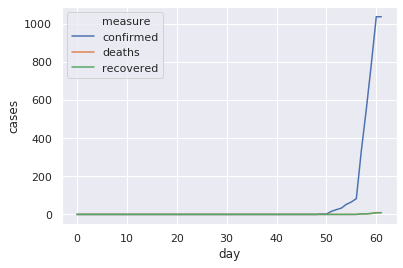

In [41]:
sns.lineplot(x='day', y='cases', hue='measure', 
             data=c19_us_state_long.loc[c19_us_state_long['State'] == 'Michigan']);

In [42]:
se_counties = ['Oakland, MI', 'Macomb, MI', 'Wayne, MI', 'Washtenaw, MI', 'St. Clair, MI']
semich_df = c19_us_county_long.loc[c19_us_county_long['Province/State'].isin(se_counties)]
semich_df


,Province/State,Country/Region,Lat,Long,date,day,State,StateAbbrev,measure,cases
188,"Oakland, MI",US,42.5922,-83.3362,2020-01-22,0,Michigan,MI,confirmed,0.0
189,"Wayne, MI",US,42.2791,-83.3362,2020-01-22,0,Michigan,MI,confirmed,0.0
379,"Oakland, MI",US,42.5922,-83.3362,2020-01-23,1,Michigan,MI,confirmed,0.0
380,"Wayne, MI",US,42.2791,-83.3362,2020-01-23,1,Michigan,MI,confirmed,0.0
570,"Oakland, MI",US,42.5922,-83.3362,2020-01-24,2,Michigan,MI,confirmed,0.0
...,...,...,...,...,...,...,...,...,...,...
35142,"Wayne, MI",US,42.2791,-83.3362,2020-03-21,59,Michigan,MI,recovered,0.0
35332,"Oakland, MI",US,42.5922,-83.3362,2020-03-22,60,Michigan,MI,recovered,0.0
35333,"Wayne, MI",US,42.2791,-83.3362,2020-03-22,60,Michigan,MI,recovered,0.0
35523,"Oakland, MI",US,42.5922,-83.3362,2020-03-23,61,Michigan,MI,recovered,NaN


In [43]:
c19_us_semich_long = pd.DataFrame(semich_df.groupby(['day', 'measure'])['cases'].sum())
c19_us_semich_long.reset_index(inplace=True)
c19_us_semich_long

,day,measure,cases
0,0,confirmed,0.0
1,0,deaths,0.0
2,0,recovered,0.0
3,1,confirmed,0.0
4,1,deaths,0.0
...,...,...,...
181,60,deaths,0.0
182,60,recovered,0.0
183,61,confirmed,0.0
184,61,deaths,0.0


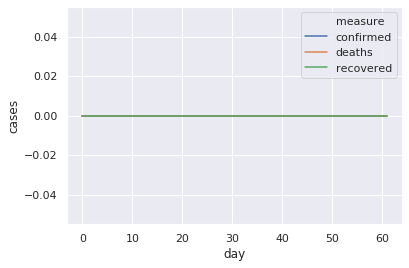

In [44]:
sns.lineplot(x='day', y='cases', hue='measure', 
             data=c19_us_semich_long);